In [3]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-07-15 13:27:59.515533 (PT)


In [5]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src/dp-gmm/util')
from pystan_vb_extract import pystan_vb_extract
import copy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pystan

In [78]:
mixture_model = """
data {
    int D;          // number of dimensions'
    int K;          // number of gaussians'
    int N;          // number of data'
    vector[D] y[N]; // data'
    vector[K] eta; // dirichlet parameter
}
parameters {
    simplex[K] w;             // mixing proportions'
    ordered[D] mu[K];             // mixture component means'
    cholesky_factor_corr[D] L[K]; // cholesky factor of covariance'
}
model {
    real ps[K];
    
    w ~ dirichlet(eta);
    
    for(k in 1:K){
       mu[k] ~ normal(0,3);
       L[k] ~ lkj_corr_cholesky(4);
    }
    for (n in 1:N){
       for (k in 1:K){
          // increment log probability of the gaussian'
          ps[k] = log(w[k]) + multi_normal_cholesky_lpdf(y[n] | mu[k], L[k]);
       }
       target += log_sum_exp(ps);
    }
}
"""

In [79]:
sm = pystan.StanModel(model_code=mixture_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_27dd9f5f76930d3200154517fdd3c7b2 NOW.


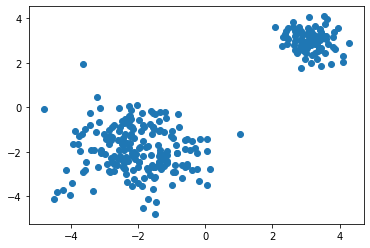

In [84]:
# Generate data
np.random.seed(1)
N1 = 100
N2 = 200
Y = np.vstack([np.random.randn(N1, 2) * .5 + 3,
               np.random.randn(N2, 2) - 2])
plt.scatter(Y[:, 0], Y[:, 1])

# Data dictionary
K = 10
data = dict(y=Y, D=Y.shape[1], N=Y.shape[0], K=K, eta=np.full(K, 1/K))

In [90]:
# Fit via ADVI
vb_fit = sm.vb(data=data, iter=2000, seed=1)

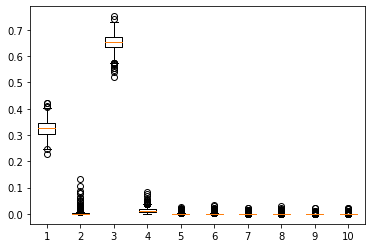

In [91]:
plt.boxplot(pystan_vb_extract(vb_fit)['w']);
# plt.boxplot(pystan_vb_extract(vb_fit)['mu']);
mu_mean = pystan_vb_extract(vb_fit)['mu'].mean(0)

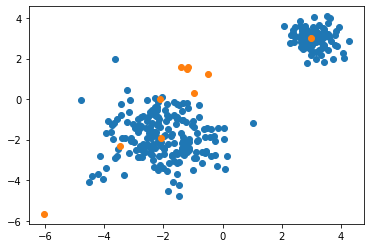

In [93]:
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(mu_mean[:, 0], mu_mean[:, 1])